In [39]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [52]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from os.path import join
from keras.losses import binary_crossentropy
import keras.backend as K
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, Dropout
from keras.optimizers import Adam
from skimage.io import imread
from skimage.transform import resize
from skimage import img_as_ubyte
import tensorflow as tf
from IPython.display import clear_output
import os
import seaborn as sns

In [41]:

ship_dir = 'data/'
train_image_dir = os.path.join(ship_dir, 'train_images')

In [42]:
DATA_PATH   = 'data/'
TRAIN_PATH  = DATA_PATH+'train_images/'
TEST_PATH   = DATA_PATH+'train_images/' 
IMG_SIZE    = (768, 768)
INPUT_SHAPE = (768, 768, 3)
TARGET_SIZE = (384, 384)
TARGET_SIZE_RGB = (384, 384, 3)
BATCH_SIZE  = 48
EPOCHS      = 100

In [43]:
train_df = pd.read_csv('train_file.csv')
train_df.head()

,Unnamed: 0,ImageId,EncodedPixels
0,2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
1,3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
2,9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...
3,18,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...
4,22,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...


Look on data

In [44]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [45]:
def get_mask(img_id, df):
  img = masks_as_image(df.query('ImageId=="'+img_id+'"')['EncodedPixels'])
  return img 

def get_image(image_name):
    img = imread(TRAIN_PATH + image_name)
    return img_as_ubyte(img)

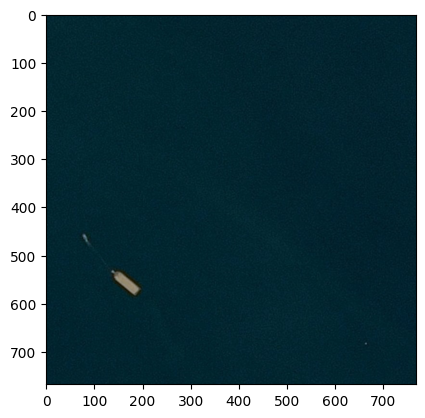

In [46]:
plt.imshow(get_image('4b53ed7ff.jpg'))

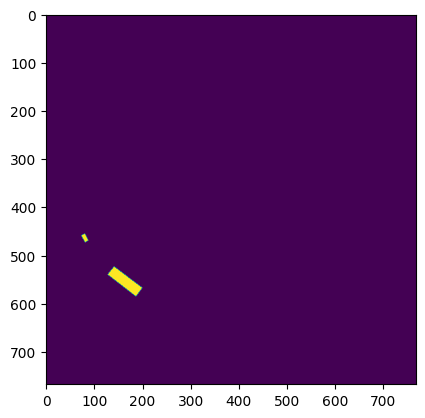

In [47]:
plt.imshow(get_mask('4b53ed7ff.jpg', train_df))

In [48]:
print(train_df.shape[0], ' masks found')
print(train_df[train_df['EncodedPixels'].notna()]['ImageId'].value_counts().shape[0], ' images with masks found')

36495  masks found
12500  images with masks found


In [49]:
print(train_df[train_df['EncodedPixels'].isna()]['ImageId'].value_counts().shape[0], ' images without masks found')

12500  images without masks found


Distribution among the count of ships

In [50]:
ships_only = train_df.dropna()

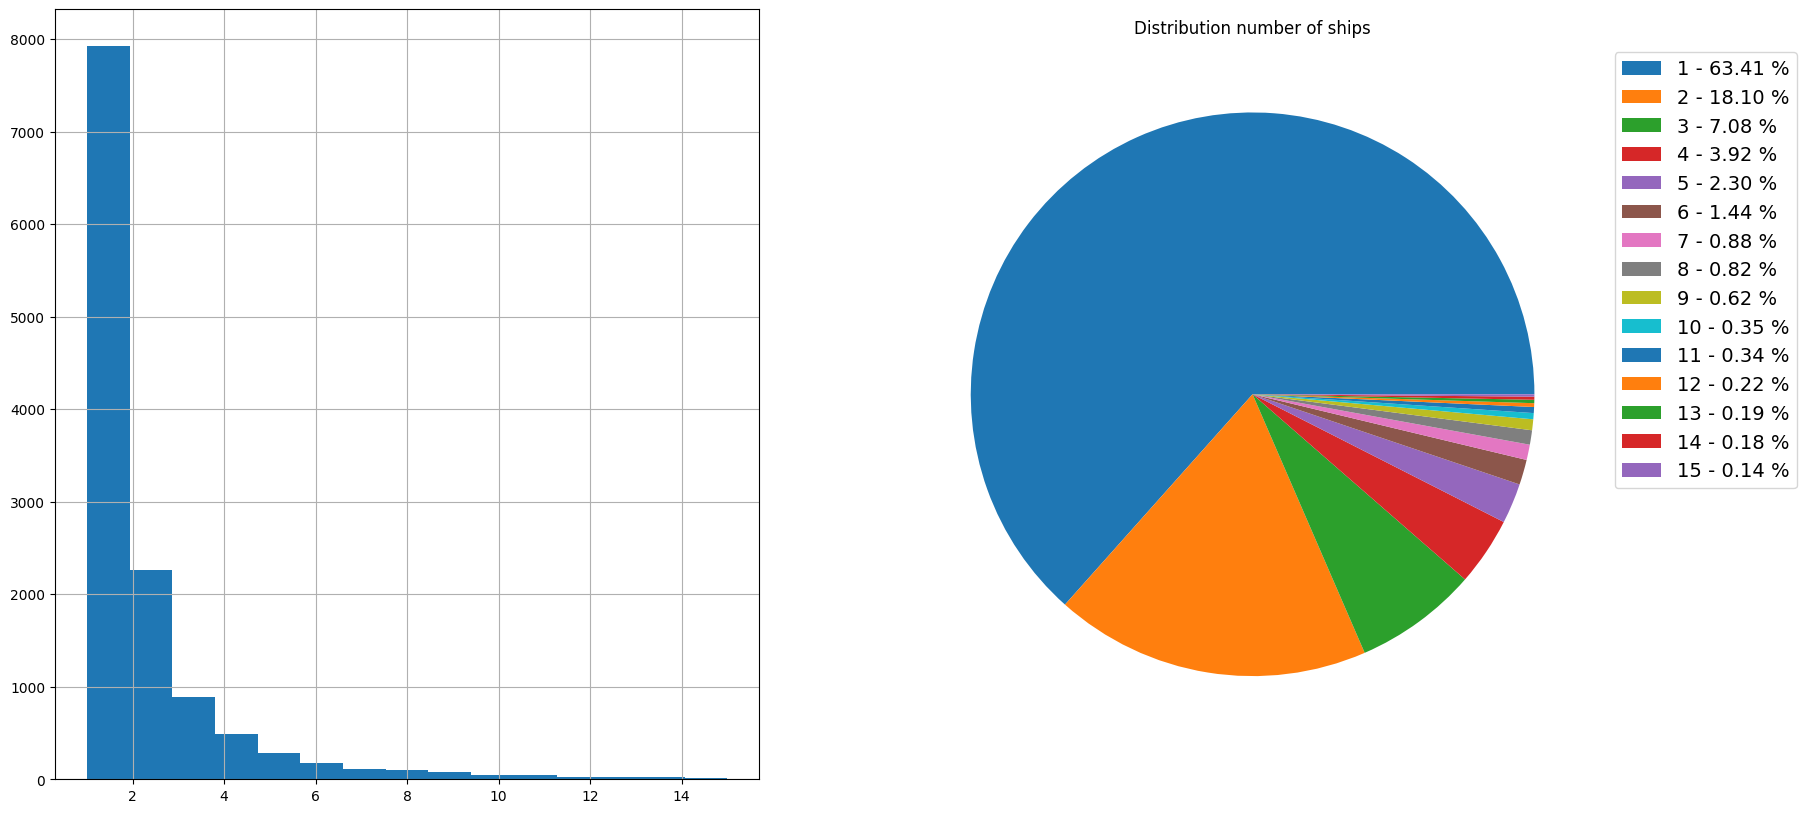

In [51]:
ships_numbers = ships_only['ImageId'].value_counts()

f,ax=plt.subplots(1, 2,figsize=(20,10))

ships_numbers.hist(bins = 15, ax=ax[0])

y = ships_numbers.value_counts().values
percent = 100.*y/y.sum()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(ships_numbers.value_counts().index.get_level_values(0), percent)]
ships_numbers.value_counts().plot.pie(labels=None, ax=ax[1])
ax[1].legend(labels, bbox_to_anchor=(1., 1.), fontsize=14)
ax[1].yaxis.set_visible(False)
ax[1].set_title('Distribution number of ships')

plt.show()

Distribution of encoded pixels size

<ipython-input-53-44bac41fd685>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ship_pixels, kde=False)


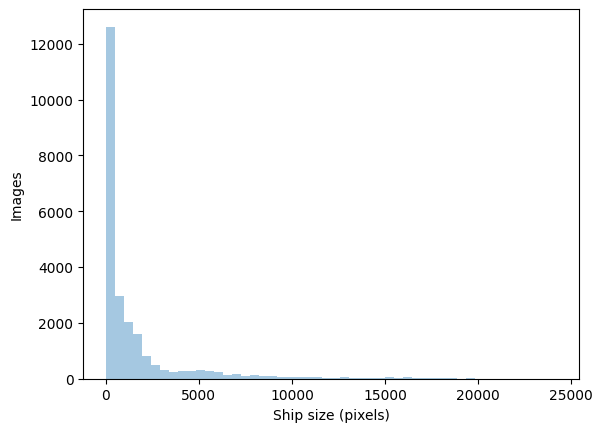

In [53]:
def ship_pixel(encodedpixels):
    if isinstance(encodedpixels, str):
        rle = np.array(list(zip(*[iter(int(x) for x in encodedpixels.split())]*2)))
    else:
        rle = np.array([])
    if rle.size > 0:
        return np.sum(rle[:,1])
    return 0

ship_pixels = ships_only.EncodedPixels.map(lambda x: ship_pixel(x))

sns.distplot(ship_pixels, kde=False)
plt.xlabel('Ship size (pixels)');
plt.ylabel('Images');

Ship area %

In [56]:
segmentations = pd.read_csv("train_file.csv")
segmentations['EncodedPixels'] = segmentations['EncodedPixels'].astype('string')
segmentations = segmentations.dropna()

In [57]:
def get_train_image(name: str):
    path = f'/kaggle/input/airbus-ship-detection/train_v2/{name}'
    return cv2.imread(path)

def extract_features_from_image(row: pd.Series) -> pd.Series:
    image = np.zeros((768, 768, 3))# get_train_image(row['ImageId'])
    row['ImageHeight'], row['ImageWidth'], _ = image.shape
    return row

segmentations = segmentations.apply(lambda x: extract_features_from_image(x), axis=1)

In [58]:
def pixels_number(encoded_pixels: str) -> int:
    if pd.isna(encoded_pixels):
        return 0
    return np.array(encoded_pixels.split()[1::2], dtype=int).sum()

segmentations['ShipAreaPercentage'] = segmentations.apply(lambda x: pixels_number(x['EncodedPixels']) / (x['ImageHeight'] * x['ImageWidth']) * 100, axis=1)

Text(0.5, 0, '')

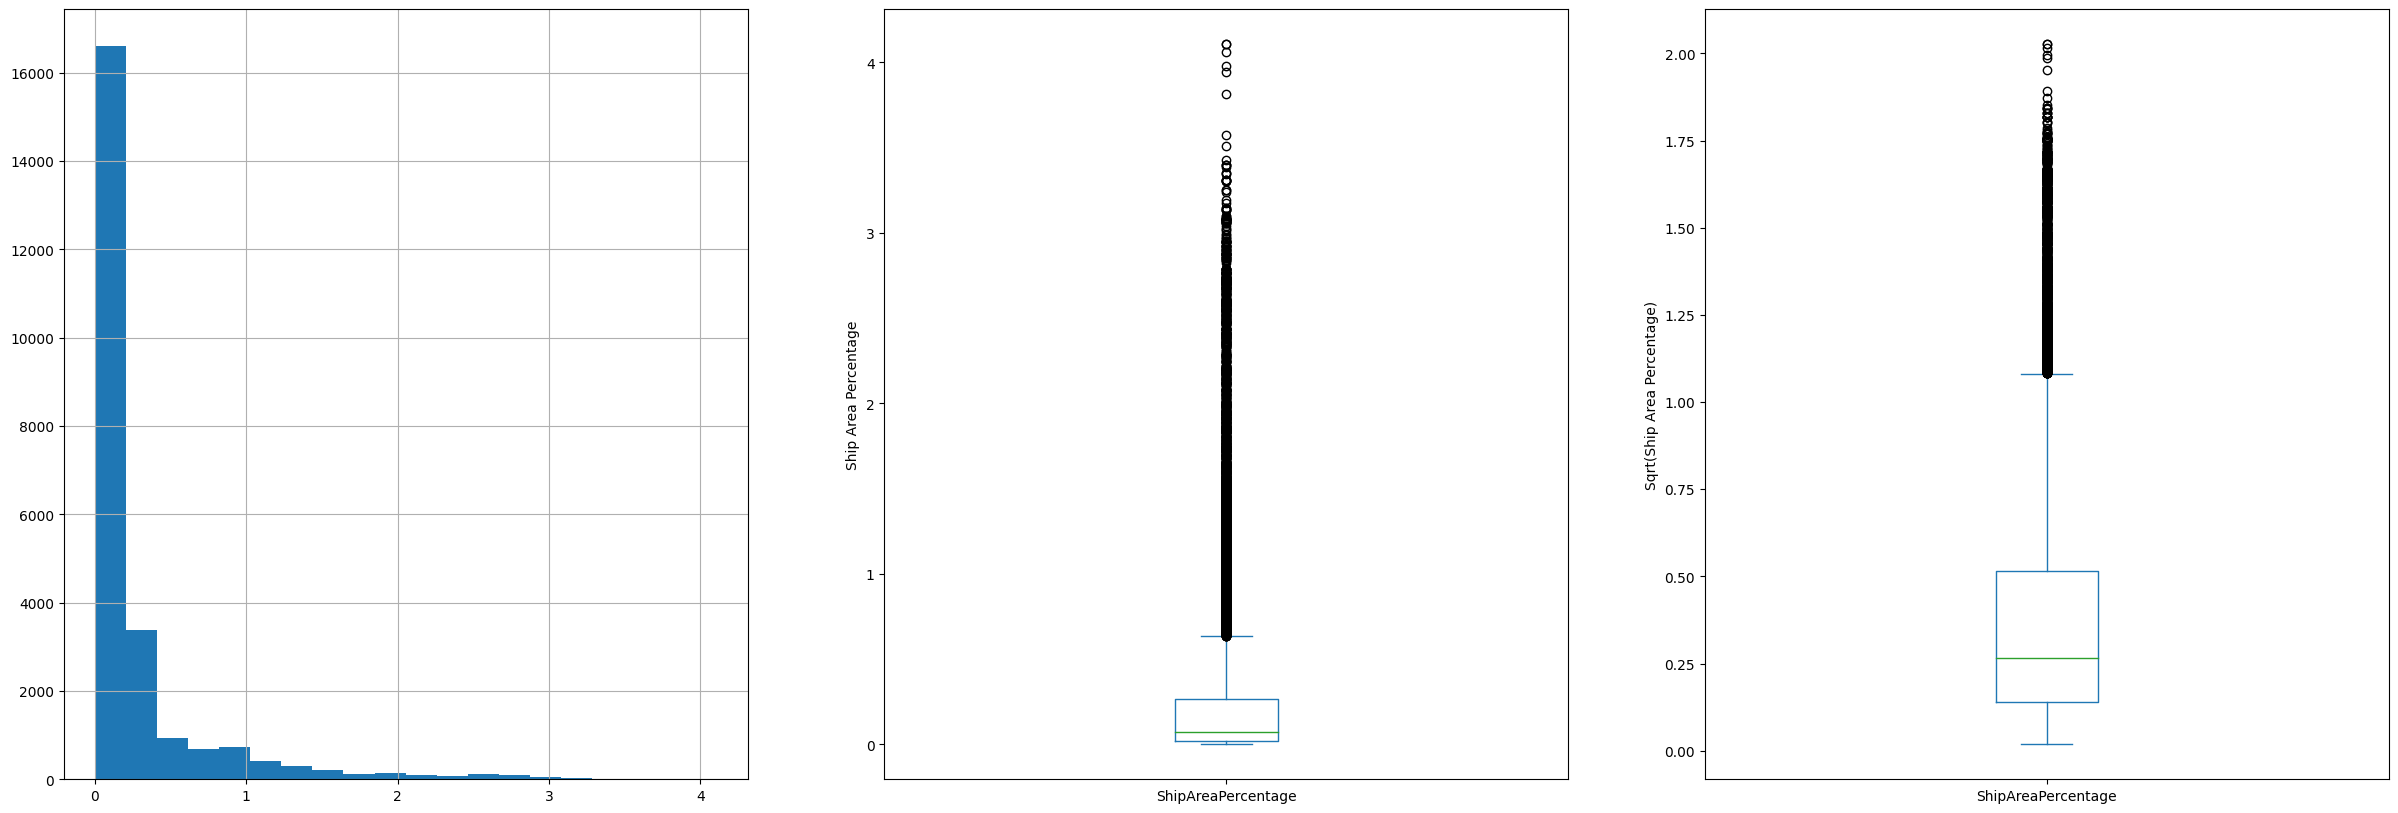

In [59]:
f,ax=plt.subplots(1, 3,figsize=(30,10))

segmentations['ShipAreaPercentage'].hist(bins=20, ax=ax[0])
segmentations['ShipAreaPercentage'].plot.box(ax=ax[1])
ax[1].set_ylabel('Ship Area Percentage')
ax[1].set_xlabel('')
segmentations['ShipAreaPercentage'].apply(lambda x: x ** 0.5).plot.box(ax=ax[2])
ax[2].set_ylabel('Sqrt(Ship Area Percentage)')
ax[2].set_xlabel('')

### Conclusion:
Data is balanced on classes ship/no ship, but only due to creating such data, on the main dataset data is imbalance ( 95% no ships to 5 % ships )

Data with ships only is imbalanced by classes ( 1 ship, 2 ships, 3 ships... ), but since the task is to only segment and do not split different ships on different classes such problem might not cause some problems 

Ships area percentage is too low. Thus, we cannot resize images too much. 
